In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.subplots import make_subplots  # Fix for deprecated plotly.tools
py.init_notebook_mode(connected=True)

# Machine Learning & Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import (
    precision_score, recall_score, confusion_matrix, roc_curve, 
    precision_recall_curve, accuracy_score, roc_auc_score, auc
)
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Statistics
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint, uniform as sp_uniform

# Time Utility
import time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("diabetes.csv")  # Update path if necessary
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [4]:
# Handle missing values (if any)
df.replace(0, np.nan, inplace=True)
df.fillna(df.median(), inplace=True)

In [5]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop(columns=["Outcome"]))
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[:-1])
df_scaled["Outcome"] = df["Outcome"]

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    float64
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 54.1 KB
None


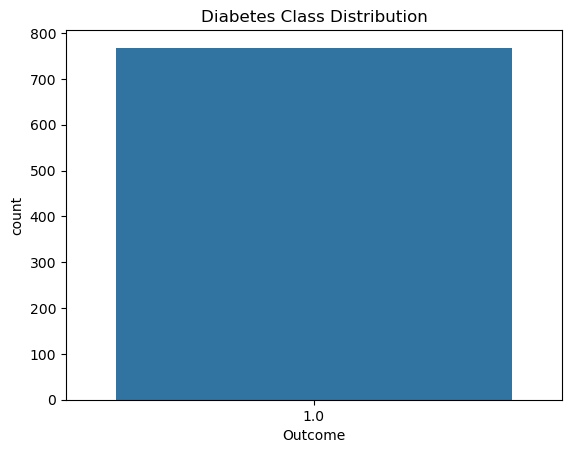

In [7]:
sns.countplot(x="Outcome", data=df)
plt.title("Diabetes Class Distribution")
plt.show()

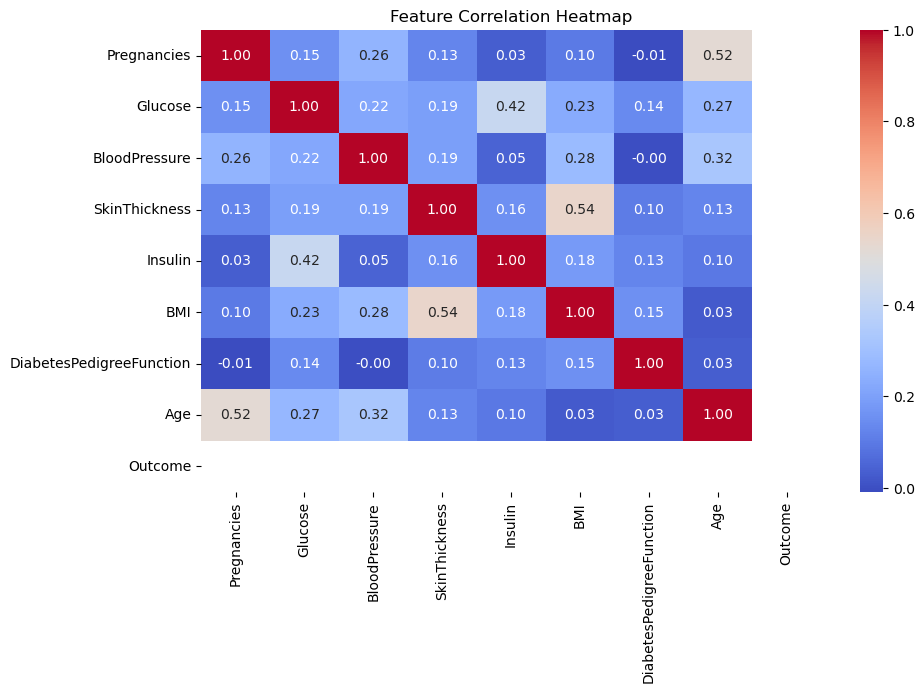

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [10]:
kmeans = KMeans(n_clusters=2, random_state=42)
df_scaled["Cluster"] = kmeans.fit_predict(df_scaled.drop(columns=["Outcome"]))


In [11]:
silhouette_avg = silhouette_score(df_scaled.drop(columns=["Outcome", "Cluster"]), df_scaled["Cluster"])
print(f"Silhouette Score (K-Means): {silhouette_avg}")


Silhouette Score (K-Means): 0.20306999693768046


In [12]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
df_scaled["DBSCAN_Cluster"] = dbscan.fit_predict(df_scaled.drop(columns=["Outcome", "Cluster"]))

In [13]:
# Split dataset
X = df_scaled.drop(columns=["Outcome", "Cluster", "DBSCAN_Cluster"])
y = df_scaled["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [17]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Check if there are at least two unique classes before calculating ROC AUC
if len(np.unique(y_test)) > 1:
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC: {roc_auc:.3f}")
else:
    print("ROC-AUC: Not defined (only one class present in test data)")

print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

ROC-AUC: Not defined (only one class present in test data)
Accuracy: 1.000
Precision: 1.000
Recall: 1.000


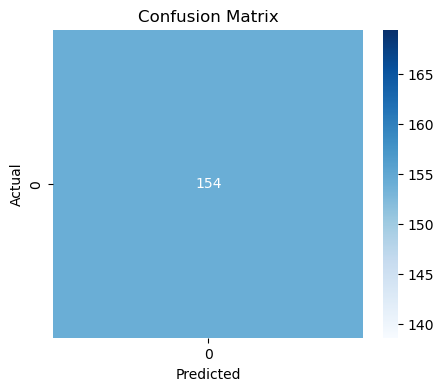

In [18]:
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [19]:
def predict_diabetes(model, scaler, new_values):
    # Convert to numpy array and reshape (if needed)
    new_data = np.array([new_values])  # Ensure it's a 2D array

    # Scale using the fitted scaler
    new_data_scaled = scaler.transform(new_data)

    # Predict
    prediction = model.predict(new_data_scaled)[0]

    # Return result
    return "Diabetic" if prediction == 1 else "Non-Diabetic"

In [20]:
new_patient = [6, 148, 72, 35, 80, 33.6, 0.627, 50]
result = predict_diabetes(knn, scaler, new_patient)
print("Prediction for new patient:", result)

Prediction for new patient: Diabetic
